<a href="https://colab.research.google.com/github/solharsh/Lending_Club_Analysis_and_Modeling/blob/master/Lending_Club_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training and Validation

I will be implementing machine learning pipelines consisting of one or more of the following steps, depending on model:

- Dimension reduction using linear discriminant analysis (LDA)
- Data standardization: rescaling to zero mean and unit variance
- The chosen model
- We will evaluate and compare the following models using a cross-validated AUROC score on the training set:

- Logistic regression with SGD training
- Random forest
- k-nearest neighbors

I will then perform some hyperparameter tuning for each model to choose the best model, then tune the hyperparameters of the best-performing model.

# 1. Importing Libraries

In [1]:
# Import our libraries we are going to use for our data analysis.
import tensorflow as tf
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.utils import class_weight


# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time

% matplotlib inline
#NLP
import nltk
nltk.download('words')
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('wordnet')
# Importing the necessary functions
import nltk, re
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
words = set(nltk.corpus.words.words())
import string

#libraries for machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.svm import LinearSVR
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#importing necessary Decision Tree libraries
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
#importing necessary Random Forest Classifier library
from sklearn.ensemble import RandomForestClassifier
#importing necessary MLP library for Neural Network
from sklearn.neural_network import MLPClassifier
#importing necessary library for Naiye Bayes
from sklearn.naive_bayes import GaussianNB
#importing necessary library for LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#importing necessary library for Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
#importing necessary library for Support Vector Machines
from sklearn.svm import SVC
#importing necessary libraries for KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
df_model = pd.read_pickle("/content/drive/My Drive/Lending_Club/loan_NLP_split.pkl")

In [27]:
df_model.head(1)

,loan_amnt,term,installment,emp_length,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,tot_coll_amt,tot_cur_bal,mort_acc,pub_rec_bankruptcies,earliest_cr_line_n,fico_avg,log_annual_inc,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_n_life_events,purpose_n_major_purchases,purpose_n_other,initial_list_status_w,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,desc,issue_d
0,5000,36,162.87,10,0,0.002765,3.0,0.0,4.135101,83.7,9.0,0.0,0.0,0.0,0.0,35.331964,737.0,4.380229,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,borrower added need upgrade business technology,2011-12-01


# 2. Checking Pearson Correlation

In [0]:
list_float = df_model.select_dtypes(exclude=['object']).columns
excluding = ['addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA',
       'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL',
       'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA',
       'addr_state_MA', 'addr_state_MD', 'addr_state_ME', 'addr_state_MI',
       'addr_state_MN', 'addr_state_MO', 'addr_state_MS', 'addr_state_MT',
       'addr_state_NC', 'addr_state_ND', 'addr_state_NE', 'addr_state_NH',
       'addr_state_NJ', 'addr_state_NM', 'addr_state_NV', 'addr_state_NY',
       'addr_state_OH', 'addr_state_OK', 'addr_state_OR', 'addr_state_PA',
       'addr_state_RI', 'addr_state_SC', 'addr_state_SD', 'addr_state_TN',
       'addr_state_TX', 'addr_state_UT', 'addr_state_VA', 'addr_state_VT',
       'addr_state_WA', 'addr_state_WI', 'addr_state_WV', 'addr_state_WY',
       'issue_d']
list_float_excluded = [col for col in list_float if col not in excluding]

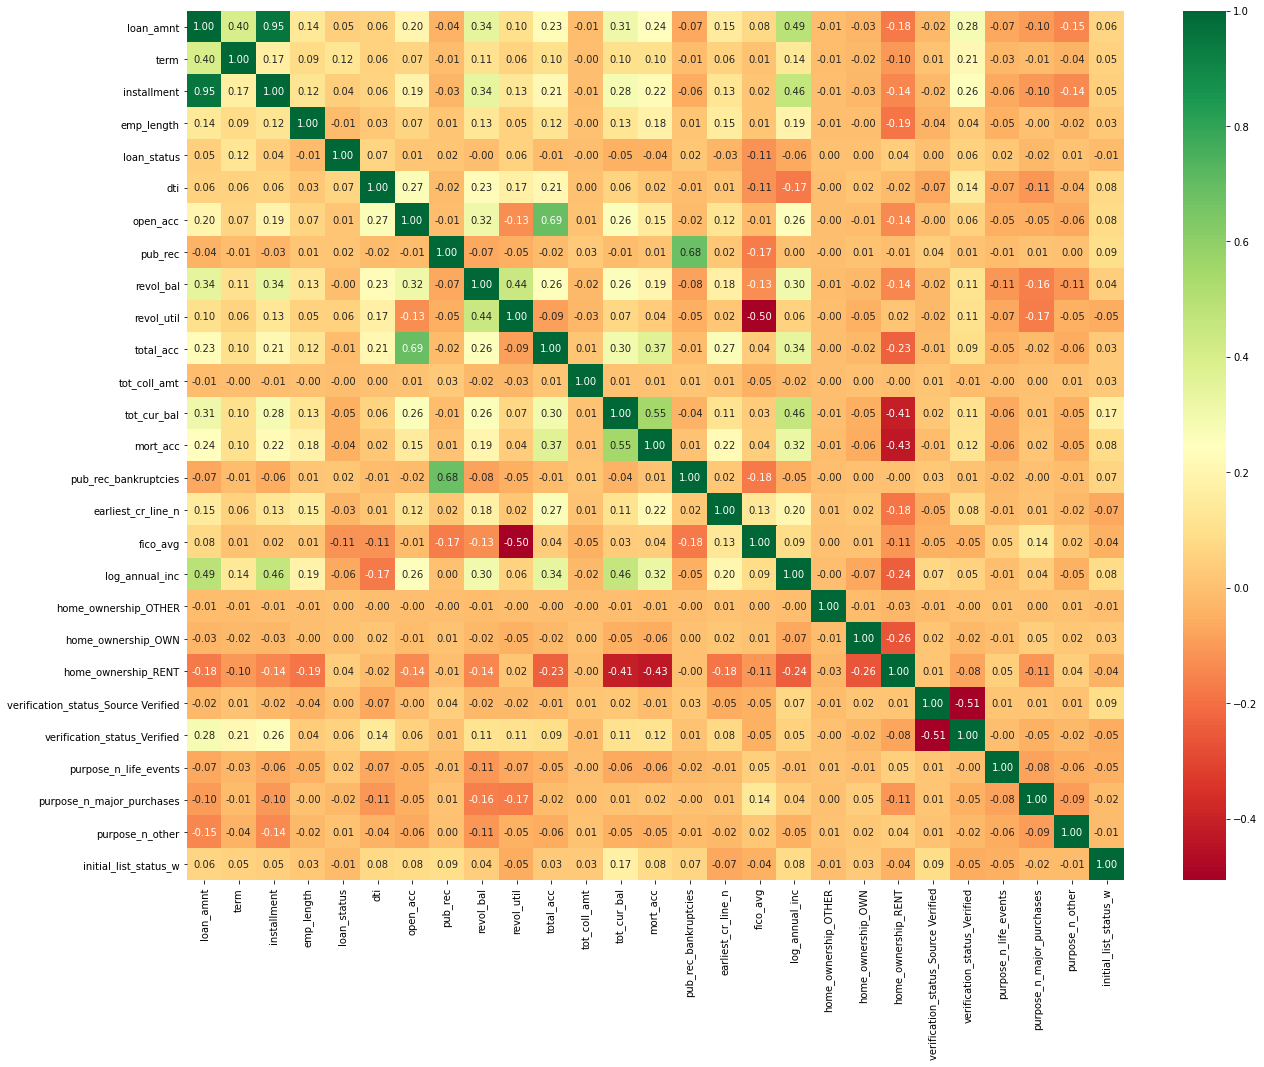

In [39]:
fig, ax = plt.subplots(figsize=(21,16))         
cm_df = sns.heatmap(df_model[list_float_excluded].corr(),annot=True, fmt = ".2f", cmap = "RdYlGn", ax=ax)

Linearly correlated features:
- "total_acc"                 vs      "open_acc"             (0.69)
- "installment"               vs      "loan_amnt"            (0.95)
- "pub_rec_bankruptcies"      vs      "pub_rec"              (0.77) 
- "tot_cur_bal"               vs      "mort_acc"             (0.55)

In [0]:
corr_list = ['total_acc','installment', 'pub_rec_bankruptcies','tot_cur_bal']

In [0]:
df_model = df_model.drop(corr_list,axis=1)

In [48]:
df_model.shape

(334262, 75)

As our pickle was created for the df and not test/train split, I have to follow same steps as last file to get test/train split. Please ignore few lines of code and refer the modeling section.

In [0]:
#We'll form the test set from the most recent 20% of the loans.
df_train = df_model.loc[df_model['issue_d'] <  df_model['issue_d'].quantile(0.8)]
df_test =  df_model.loc[df_model['issue_d'] >= df_model['issue_d'].quantile(0.8)]

As 'issue_d' does not convey any information about the borrower and we kept it only to get the data split as per the required format, removing it now as it indicates information only about the date when the loan was funded. Therefore we will drop 'issue_d' and continue without it.

In [50]:
df_train.drop('issue_d', axis=1, inplace=True)
df_test.drop('issue_d', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#Now separate the predictor variables from the response variable:
y_train = df_train['loan_status']
y_val = df_test['loan_status']

In [0]:
X_train = df_train.drop('loan_status', axis=1)
X_val = df_test.drop('loan_status', axis=1)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
# Initialize the binary count vectorizer #Text -> Uni gram count Vectors
tfidf_vectorizer = CountVectorizer(binary=True,
                                   max_features=100    # Limit the vocabulary size
                                  )
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["desc"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["desc"].tolist())

In [0]:
X_train = X_train.drop(['desc'],axis=1) #dropping desc from X_train as we have processed it in X_train_text_vectors
X_val = X_val.drop(['desc'],axis=1) #dropping desc from X_val as well as we have processed it in X_val_text_vectors

In [0]:
# Let' merge our features
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train)
                                  )
# Let' merge our features
X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                    X_val)
                                  )

In [0]:
list_float = df_model.select_dtypes(exclude=['object']).columns
list_float_excluded = [col for col in list_float if col not in excluding]

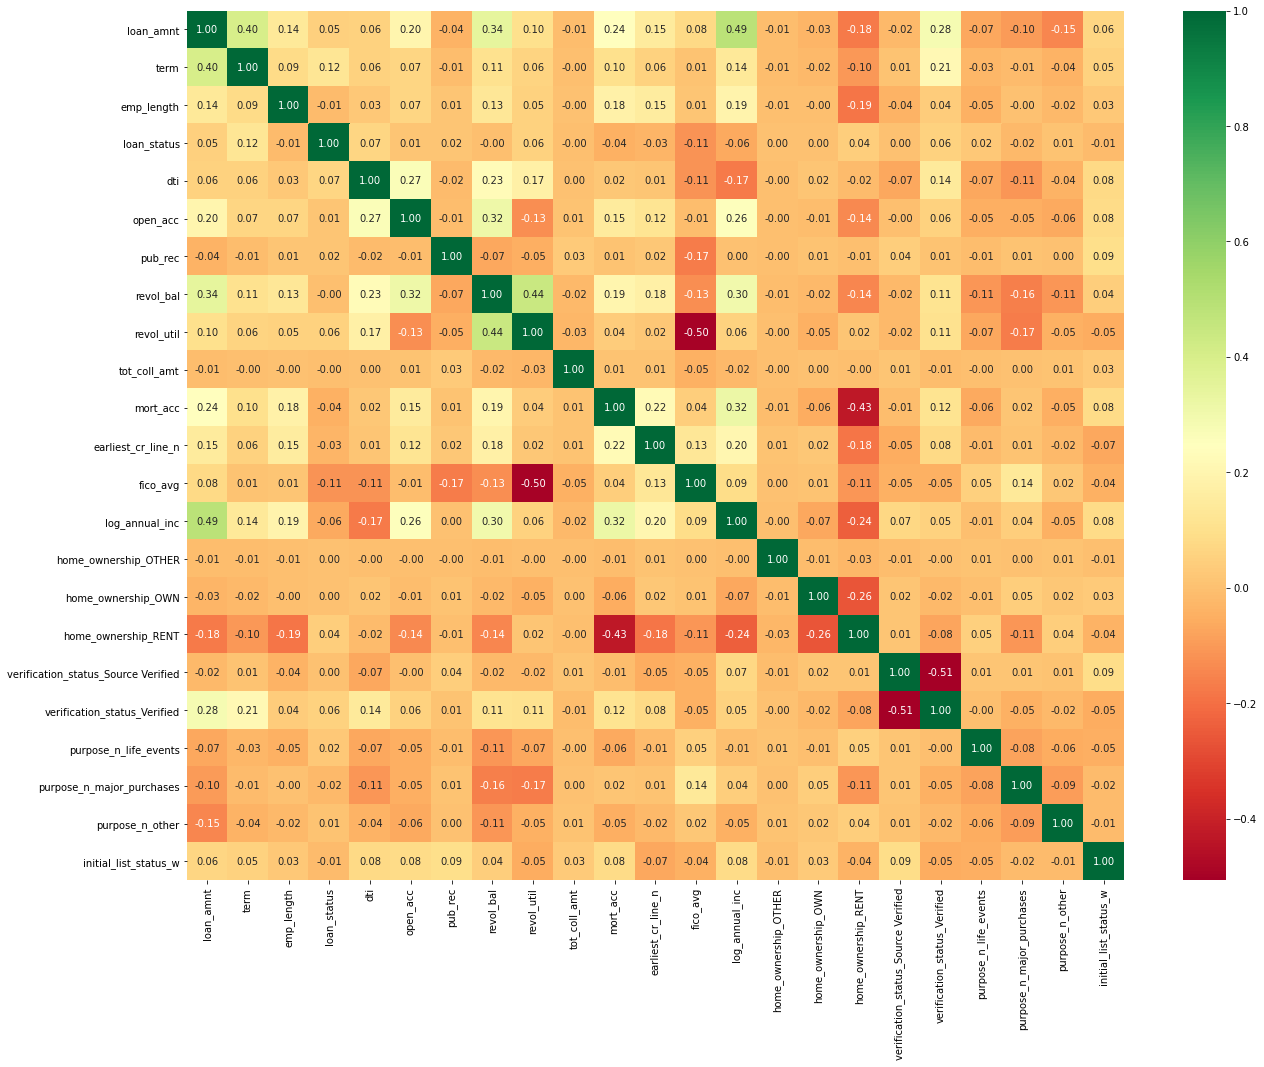

In [58]:
fig, ax = plt.subplots(figsize=(21,16))         
cm_df = sns.heatmap(df_model[list_float_excluded].corr(),annot=True, fmt = ".2f", cmap = "RdYlGn", ax=ax)